### Cleaning

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Data/subreddit_data.csv')

In [3]:
df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,"I was suggested to post this puzzle here ,hope...",NaN,chess,1645890879
1,1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",chess,1645889769
2,2,Who is GM Watneg on lichess?,NaN,chess,1645887353
3,3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,chess,1645886429
4,4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,chess,1645885215


In [4]:
# Binarize the subreddit column to 0s (chess) and 1 (nba).  Doesn't matter what the positive class is.  Baseline Model will be ~50% accurate either way.

df['subreddit'] = df['subreddit'].replace({'chess': 0, 'nba':1})

In [5]:
df.isnull().sum()

Unnamed: 0        0
title             0
selftext       1761
subreddit         0
created_utc       0
dtype: int64

In [6]:
# Impute NaNs with an empty string
df['selftext'].fillna('',inplace = True)

In [7]:
# Drop the 'created_utc' column
df.drop(columns = 'created_utc', inplace = True)

### EDA

In [8]:
# Add a new column for title length
df['title_length'] = df['title'].str.len()

In [9]:
# Add a new column for title word count
df['title_word_count'] = [len(title.split(' ')) for title in df['title']]

In [10]:
df.head()

,Unnamed: 0,title,selftext,subreddit,title_length,title_word_count
0,0,"I was suggested to post this puzzle here ,hope...",,0,65,14
1,1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7
2,2,Who is GM Watneg on lichess?,,0,28,6
3,3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4
4,4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34


In [11]:
df.sort_values('title_word_count', ascending = False)[['title']]

,title
2939,Krause on MJ: He knew that he could do things ...
2002,[ESPN Stats &amp; Info] A new Big 3 brewing in...
279,Why is this move that good? I've been analyzin...
3643,"[Vardon] Giannis: “All-Star Games, they are no..."
3024,Danny Green on if Simmons will play March 10th...
...,...
1220,Help
3145,Hdjsusbeebbggff
1844,1660
216,Hi!


Text(0, 0.5, '# of documents')

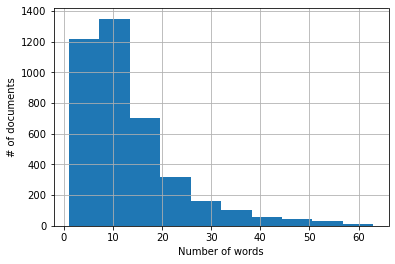

In [12]:
df['title_word_count'].hist()
plt.xlabel('Number of words')
plt.ylabel('# of documents')

Text(0, 0.5, '# of documents')

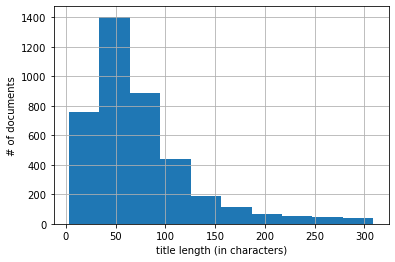

In [13]:
df['title_length'].hist()
plt.xlabel('title length (in characters)')
plt.ylabel('# of documents')

In [14]:
df.groupby('subreddit')['title_length','title_word_count'].mean()

C:\Users\aorfa\AppData\Local\Temp/ipykernel_3708/918172363.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('subreddit')['title_length','title_word_count'].mean()


,title_length,title_word_count
subreddit,,
0,63.265899,11.472208
1,85.109500,15.130000


### Vectorize the text

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [16]:
cvec = CountVectorizer(stop_words = 'english')

cvec.fit(df['title'])

csr = cvec.transform(df['title'])

title_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [17]:
title_cvec.shape

(3997, 6188)

In [18]:
# top 20 words in either subreddit titles

title_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

chess        547
game         457
nba          346
play         218
white        208
time         181
black        179
lebron       174
team         166
star         158
players      151
win          149
just         138
highlight    138
best         137
games        136
player       126
com          123
like         110
mate         107
dtype: int64

In [19]:
# create new dataFrame with only the titles from the chess subreddit.  
df_chess = df[(df['subreddit'] == 0)]

In [20]:
df.shape

(3997, 6)

In [21]:
df_chess.shape

(1997, 6)

In [22]:
df_chess['subreddit'].value_counts()

0    1997
Name: subreddit, dtype: int64

In [23]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_chess['title'])
csr = cvec.transform(df_chess['title'])
chess_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [24]:
# Top 20 words in chess subreddit titles

chess_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

chess       547
game        230
white       201
black       177
play        168
com         117
mate        107
win          98
just         76
lichess      70
games        69
best         68
does         60
playing      58
like         58
position     56
moves        53
time         53
players      52
draw         52
dtype: int64

In [25]:
df_nba = df[(df['subreddit'] == 1)]

In [26]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_nba['title'])
csr = cvec.transform(df_nba['title'])
nba_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [27]:
# Top 20 words in nba subreddit titles

nba_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

nba          346
game         227
lebron       174
team         161
star         158
highlight    138
time         128
season       100
harden       100
players       99
james         96
curry         92
player        87
lakers        85
steph         73
best          69
games         67
mvp           65
2022          65
thread        64
dtype: int64

In [ ]:
df['title']

In [43]:
# try vectorizing on a token pattern that detects any two consecutive capitalized words

cvec = CountVectorizer(stop_words = 'english', lowercase = False, token_pattern = '([A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+)')
cvec.fit(df['title'])
csr = cvec.transform(df['title'])
twocaps_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [44]:
twocaps_cvec.head()

,Aaron Fox,Aaron Fox Scams,Aaron Gordon,Aaron Holiday,Abram Khasin,Adam Aaronson,Adds Durant,Adult Improver,Affiliate Club,After Esipenko,...,Your Thoughts,Your Workouts,Youtube Channels,Yrs Old Non,Yugoslav Grandmaster,Yuri Averbakh,Yury Averbakh,Zach La,Zach Lowe,Zion Williamson
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sentiment Analysis

In [28]:
# Add Sentiment score columns to the main df
# Instantiate Sentiment Intensity Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [29]:
df['sentiment'] = df['title'].apply(sia.polarity_scores)
df.head()

,Unnamed: 0,title,selftext,subreddit,title_length,title_word_count,sentiment
0,0,"I was suggested to post this puzzle here ,hope...",,0,65,14,"{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp..."
1,1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2,Who is GM Watneg on lichess?,,0,28,6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,"{'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'comp..."


In [30]:
df['sentiment_compound'] = df['sentiment'].map(lambda x: x['compound'])
df['sentiment_negative'] = df['sentiment'].map(lambda x: x['neg'])
df['sentiment_neutral'] = df['sentiment'].map(lambda x: x['neu'])
df['sentiment_positive'] = df['sentiment'].map(lambda x: x['pos'])
df = df.drop('sentiment', 1)

C:\Users\aorfa\AppData\Local\Temp/ipykernel_1960/1652361034.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('sentiment', 1)


In [31]:
df.head()

,Unnamed: 0,title,selftext,subreddit,title_length,title_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive
0,0,"I was suggested to post this puzzle here ,hope...",,0,65,14,0.8126,0.000,0.543,0.457
1,1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,0.0000,0.000,1.000,0.000
2,2,Who is GM Watneg on lichess?,,0,28,6,0.0000,0.000,1.000,0.000
3,3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,0.0000,0.000,1.000,0.000
4,4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,-0.5043,0.121,0.879,0.000


In [32]:
df.to_csv('./Data/subreddit_data_post_eda.csv')